In [75]:
# cd into project directory 
%cd /home/baldeeb/Documents/Projects/ContrastiveLearningOfDenseDescriptor

%load_ext autoreload
%autoreload 2

/home/baldeeb/Documents/Projects/ContrastiveLearningOfDenseDescriptor
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Clustering stuff

## First: Get data and make a visualization function 

In [76]:
# Tools needed to setup data loader
from dataset import make_data_loader
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from tqdm import tqdm 
import numpy as np
import random 
import torch

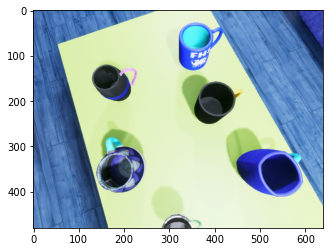

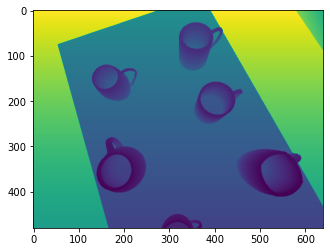

In [77]:
# Selecting image

class dataset_cfg():
    dataset = 'unreal_parts'
    data_dir = '../simple_data'
    image_type = 'RGB'
    batch_size = 1
    workers = 1

%matplotlib inline 
unreal_data = make_data_loader(split='train', args=dataset_cfg(), return_dataset=True)
unreal_data.iterate_randomly = False

idx = random.randint(0, len(unreal_data))
data = unreal_data[idx]
image = data['image']

plt.figure(10)
plt.imshow(image.permute(1,2,0))
plt.figure(11)
plt.imshow( data['depth'])

In [78]:
# #############################################################################
# Plot result
def plot_clusters(db, data):
    fig = plt.figure()
    if data.shape[1] == 1: ax = fig.add_subplot(111)
    elif data.shape[1] == 3: ax = fig.add_subplot(111, projection='3d')

    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    for i, (k, col) in enumerate(zip(unique_labels, colors)):
        if k == -1: col = [0, 0, 0, 1] # Black used for noise.

        class_member_mask = (labels == k)
        xy = data[class_member_mask & core_samples_mask]
        idxs = random.sample(range(len(xy)), min(len(xy), 1000))
        

        if data.shape[1] == 3:
            ax.scatter3D(xs=xy[idxs, 0], ys=xy[idxs, 1], zs=xy[idxs, 2], color=tuple(col), alpha=0.35)
        elif data.shape[1] == 1:
            # plt.plot(range(len(xy)), xy)
            plt.scatter(np.ones(len(xy))*k, xy, color=tuple(col), alpha=0.35)

        if i >= len(unique_labels): break

## Now clustering in depth

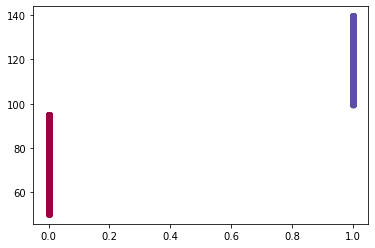

In [79]:
## Cluster in depth 
%matplotlib inline 

depth = data['depth'].reshape(-1, 1)
# idx = random.sample(range(depth.shape[0]), int(depth.shape[0]/200))
idx = random.sample(range(depth.shape[0]), int(10000))
depth = depth[idx, :]
db = DBSCAN(eps=2, min_samples=100).fit(depth)
plot_clusters(db, depth)

In [80]:
unique_labels = set(db.labels_)

cluster_of_minimum_max_depth = -1
minimum_max = 99999
for k in unique_labels:
    if k == -1: continue
    mask = db.labels_ == k
    max_depth = depth[mask].max()
    if max_depth < minimum_max:
        minimum_max = max_depth
        cluster_of_minimum_max_depth = k 


cluster_of_minimum_max_depth    

0

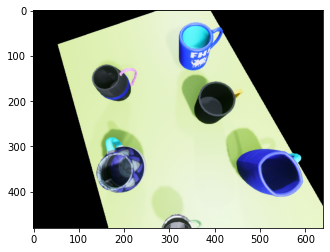

In [81]:
generated_forground_mask = np.zeros_like(data['depth'])
generated_forground_mask[data['depth'] < minimum_max] = 1
image = data['image'].clone()
image[:, generated_forground_mask==0] = 0

plt.figure()
plt.imshow(image.permute(1,2,0))
# plt.imshow(generated_forground_mask)

## Now cluster dense blobs

# TODOOOOOOOO

In [82]:
%matplotlib qt 
# %matplotlib inline 

xyz = unreal_data.get_projected_indices(data)
xyz_image = xyz.reshape(-1, unreal_data.height, unreal_data.width)
xyz_image[:, generated_forground_mask == 0] = 0

fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')

# idxs = random.sample(range(len(xyz)), min(len(xyz), 1000))
# vis_xyz = xyz[idxs].T
vis_xyz = xyz_image

ax.scatter3D(xs=vis_xyz[0], ys=vis_xyz[1], zs=vis_xyz[2], color='b', alpha=0.35)

In [85]:
## Cluster in xyz
to_cluster = xyz_image.reshape(3, -1).T

db = DBSCAN(eps=1, min_samples=10).fit(to_cluster)
plot_clusters(db, xyz)